In [1]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch import nn
import torch_geometric.nn as geom_nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))

def add_const_parameter(data,const_param):

    ### Given a numpy array of size m*n , it will return a numpy array of size m*(n+1), where
    ### the last column has all elements as const_param ###

    add_column = np.ones(len(data))*const_param
    
    return np.hstack((data, add_column[:,None]))


def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 

### Validation ###
# print(all_dat[0].edge_index[:,0:5])
# test = mirror_edge_index(all_dat[0].edge_index[:,0:5].detach().cpu().numpy())
# print(test)

In [3]:
### Reading Raw Data ###
df = pd.read_csv('AR2p5_all_particle_drag.dat.csv', header=0)
all_tags = np.load("ze_tags_2p5.npy")

### Read all center data ###
center_10 = pd.DataFrame(np.loadtxt("center_phi_10.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10_dev = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("center_phi_20.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20_dev = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("center_phi_30.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30_dev = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

### Defining all particles ###
center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]

all_particles = np.concatenate((center_shifted_10,center_shifted_20,center_shifted_30))

In [4]:
# ### Defining Real particles ###
# variable_list = ['Center_x','Center_y','Center_z','phi','Re','Inclination_angle','Drag_local']
# real_particles = df[(df["Center_x"]>7.5)&(df["Center_x"]<17.5)][variable_list]

In [5]:
# ### Generate Dataset ###
# ### getting 15 nearest neighbors indices ###
# tree = cKDTree(all_particles)
# idx = np.stack([tree.query(real_particles.iloc[i][["Center_x","Center_y","Center_z"]].values,16)[1] for i in range(len(real_particles))])

# ### Bringing it all together ###
# all_data = list()
# for i in range(len(real_particles)):
#     print("On particle : ",str(i+1))
#     temp_poi = real_particles.iloc[i][["Center_x","Center_y","Center_z","Re","phi","Inclination_angle","Drag_local"]].values
#     temp_neighbors = np.array(df.iloc[idx[0][1:]][["Center_x","Center_y","Center_z"]]).flatten()
#     all_data.append(np.concatenate((temp_poi[0:3], temp_neighbors, temp_poi[3:])))
#     clear_output(wait=True)

In [6]:
### Generate dataset corrected ###

### Sf=0.1 ###
### Generating the n nearest neighbors ###
tree = cKDTree(center_shifted_10.values)
idx = np.stack([tree.query(center_10_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_10_dev))])
input_dat_sf10 = np.stack([center_shifted_10.iloc[idx[i]] for i in range(len(idx))])
input_dat_sf10 = input_dat_sf10.reshape(input_dat_sf10.shape[0],input_dat_sf10.shape[1]*input_dat_sf10.shape[2])

### Adding solid fraction column ###
input_dat_sf10 = add_const_parameter(input_dat_sf10,0.1)

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat_sf10 = np.vstack( ( add_const_parameter(input_dat_sf10,10),
                   add_const_parameter(input_dat_sf10,50),
                   add_const_parameter(input_dat_sf10,100),
                   add_const_parameter(input_dat_sf10,200),
                    ) )

### Joing with df array to get inclination and drag and other quantities if needed ###
join_additions = list()
for i in range(len(input_dat_sf10)):
    idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf10[i][[0,1,2,-1]]).all(axis=1) )
    join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
input_dat_sf10 = np.hstack((input_dat_sf10,np.stack(join_additions)))


### Sf=0.2 ###
### Generating the n nearest neighbors ###
tree = cKDTree(center_shifted_20.values)
idx = np.stack([tree.query(center_20_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_20_dev))])
input_dat_sf20 = np.stack([center_shifted_20.iloc[idx[i]] for i in range(len(idx))])
input_dat_sf20 = input_dat_sf20.reshape(input_dat_sf20.shape[0],input_dat_sf20.shape[1]*input_dat_sf20.shape[2])

### Adding solid fraction column ###
input_dat_sf20 = add_const_parameter(input_dat_sf20,0.2)

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat_sf20 = np.vstack( ( add_const_parameter(input_dat_sf20,10),
                   add_const_parameter(input_dat_sf20,50),
                   add_const_parameter(input_dat_sf20,100),
                   add_const_parameter(input_dat_sf20,200),
                    ) )

### Joing with df array to get inclination and drag and other quantities if needed ###
join_additions = list()
for i in range(len(input_dat_sf20)):
    idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf20[i][[0,1,2,-1]]).all(axis=1) )
    join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
input_dat_sf20 = np.hstack((input_dat_sf20,np.stack(join_additions)))


### Sf=0.3 ###
### Generating the n nearest neighbors ###
tree = cKDTree(center_shifted_30.values)
idx = np.stack([tree.query(center_30_dev.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(center_30_dev))])
input_dat_sf30 = np.stack([center_shifted_30.iloc[idx[i]] for i in range(len(idx))])
input_dat_sf30 = input_dat_sf30.reshape(input_dat_sf30.shape[0],input_dat_sf30.shape[1]*input_dat_sf30.shape[2])

### Adding solid fraction column ###
input_dat_sf30 = add_const_parameter(input_dat_sf30,0.3)

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat_sf30 = np.vstack( ( add_const_parameter(input_dat_sf30,10),
                   add_const_parameter(input_dat_sf30,50),
                   add_const_parameter(input_dat_sf30,100),
                   add_const_parameter(input_dat_sf30,200),
                    ) )

### Joing with df array to get inclination and drag and other quantities if needed ###
join_additions = list()
for i in range(len(input_dat_sf30)):
    idx = np.where( (df[["Center_x","Center_y","Center_z","Re"]]==input_dat_sf30[i][[0,1,2,-1]]).all(axis=1) )
    join_additions.append(df.iloc[idx][["Inclination_angle","Drag_local"]].values[0])
input_dat_sf30 = np.hstack((input_dat_sf30,np.stack(join_additions)))

### Combining all three solid fractions ###
all_data = np.vstack((input_dat_sf10,input_dat_sf20,input_dat_sf30))

In [7]:
### Converting to DataFrame and renaming the columns ###
all_data_pd = pd.DataFrame(all_data,columns=["POI_x_coord","POI_y_coord","POI_z_coord",
                                             "neigh_1_x","neigh_1_y","neigh_1_z",
                                             "neigh_2_x","neigh_2_y","neigh_2_z",
                                             "neigh_3_x","neigh_3_y","neigh_3_z",
                                             "neigh_4_x","neigh_4_y","neigh_4_z",
                                             "neigh_5_x","neigh_5_y","neigh_5_z",
                                             "neigh_6_x","neigh_6_y","neigh_6_z",
                                             "neigh_7_x","neigh_7_y","neigh_7_z",
                                             "neigh_8_x","neigh_8_y","neigh_8_z",
                                             "neigh_9_x","neigh_9_y","neigh_9_z",
                                             "neigh_10_x","neigh_10_y","neigh_10_z",
                                             "neigh_11_x","neigh_11_y","neigh_11_z",
                                             "neigh_12_x","neigh_12_y","neigh_12_z",
                                             "neigh_13_x","neigh_13_y","neigh_13_z",
                                             "neigh_14_x","neigh_14_y","neigh_14_z",
                                             "neigh_15_x","neigh_15_y","neigh_16_z",
                                              "Re","Phi","Inclination_angle","Drag_local"])
all_data_pd

,POI_x_coord,POI_y_coord,POI_z_coord,neigh_1_x,neigh_1_y,neigh_1_z,neigh_2_x,neigh_2_y,neigh_2_z,neigh_3_x,...,neigh_14_x,neigh_14_y,neigh_14_z,neigh_15_x,neigh_15_y,neigh_16_z,Re,Phi,Inclination_angle,Drag_local
0,10.876728,8.580914,1.499941,10.469863,8.375915,0.380001,12.365468,8.985445,1.470692,10.506291,...,10.289643,5.810538,1.279047,10.606896,9.100682,-1.328129,0.1,10.0,32.081738,3.903370
1,12.929652,8.518986,8.546638,13.137204,7.388673,9.134358,14.129487,8.677728,7.693470,11.575088,...,10.895257,7.021219,7.350211,13.048629,11.408079,8.215324,0.1,10.0,77.315739,5.023779
2,17.018229,8.503029,1.464684,15.846247,8.562797,1.726459,17.168299,7.801587,2.762035,16.039233,...,17.174782,5.640941,1.141856,17.064104,11.427227,1.433072,0.1,10.0,52.642073,4.573232
3,16.603652,1.499732,9.825560,16.301634,1.485659,8.521393,17.064104,1.427227,11.433072,15.314176,...,19.257693,0.879646,7.689390,16.342990,4.722934,11.133123,0.1,10.0,60.625083,6.699245
4,11.737969,1.485545,9.792119,12.637778,2.087273,10.319745,11.783217,0.809170,8.702602,11.933656,...,12.313261,3.501501,7.937789,11.646745,1.887016,7.009987,0.1,10.0,51.275008,7.034383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,9.057059,2.669999,8.314206,9.057284,1.479232,8.514042,9.907359,3.192568,7.614087,8.976140,...,10.505298,1.274095,7.834280,7.403339,1.490008,7.876967,0.3,200.0,77.808798,53.346913
4732,15.632600,6.765237,6.832840,15.239347,6.916532,6.021430,16.421408,7.283360,7.003994,15.010621,...,16.784087,7.884691,7.602738,16.362163,5.295331,7.739148,0.3,200.0,54.035214,44.935589
4733,12.114195,7.278870,6.658870,12.232537,7.903498,5.784083,12.286162,6.688021,5.679663,11.958974,...,14.028744,7.742799,6.464971,12.291097,8.348837,4.924854,0.3,200.0,38.850731,44.519320
4734,13.199404,1.211223,9.910920,12.188506,1.198308,10.293343,13.789863,1.323076,8.807014,14.435418,...,14.078235,0.098073,11.249544,12.060460,0.083602,8.795183,0.3,200.0,47.605903,30.597811


In [8]:
## Translating the POI to the origin (keeping the POI coord values global , but making all the neighbors relative to it)###

## x-axis ###
all_data_pd.loc[:, all_data_pd.columns.str.endswith('_x')] -= all_data_pd["POI_x_coord"].values[:,None]
### y-axis ###
all_data_pd.loc[:, all_data_pd.columns.str.endswith('_y')] -= all_data_pd["POI_y_coord"].values[:,None]
### z-axis ###
all_data_pd.loc[:, all_data_pd.columns.str.endswith('_z')] -= all_data_pd["POI_z_coord"].values[:,None]

In [9]:
### Splitting data as train and test ###
check_points = np.array([0,center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],
          center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],
         center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0]]).cumsum() 

test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
train_indices = np.setdiff1d( np.arange(len(all_data_pd)) , test_indices )

train_data_pd = all_data_pd.iloc[train_indices]
test_data_pd = all_data_pd.iloc[test_indices]

In [10]:
### Scaling the train and test dataset ###
scaler = MinMaxScaler()
scaler.fit(train_data_pd)
train_data_pd_scaled = scaler.transform(train_data_pd)
test_data_pd_scaled = scaler.transform(test_data_pd)

### splitting to input and outputs ##3
train_inputs,train_outputs = train_data_pd_scaled[:,0:51],train_data_pd_scaled[:,51:]
test_inputs,test_outputs = test_data_pd_scaled[:,0:51],test_data_pd_scaled[:,51:]

In [76]:
### Define MLP model ###
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(51, 128),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(16, 1) 
        )

    def forward(self, x):
        return self.layers(x)
        
model =  MLP()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

21697


In [77]:
### Define Train and Test and loaders ###
train_loader = DataLoader(list(zip(train_inputs,train_outputs)), batch_size=16, shuffle=True)
test_loader = DataLoader(list(zip(test_inputs,test_outputs)), batch_size=16, shuffle=True)

In [78]:
model =  MLP().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0055)

epoch_loss_train = list()
epoch_loss_val = list()

for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        # targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = model(inputs)

        # print("GT and Pred :",str(targets),str(outputs))
        
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for i, data in enumerate(test_loader, 0):

        inputs, targets = data
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        loss = loss_function(outputs, targets)
        loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())    

print("Training has completed")

Starting Epoch 1
Epoch 1 finished with training loss = 0.008401158026374065
testing loss = 0.04175165941317876

Starting Epoch 2
Epoch 2 finished with training loss = 0.004155436438911846
testing loss = 0.03955613654106856

Starting Epoch 3
Epoch 3 finished with training loss = 0.003822146569592248
testing loss = 0.04116183407604694

Starting Epoch 4
Epoch 4 finished with training loss = 0.003682269662254511
testing loss = 0.06528766093154749

Starting Epoch 5
Epoch 5 finished with training loss = 0.0035968622215935974
testing loss = 0.0499700715765357

Starting Epoch 6
Epoch 6 finished with training loss = 0.0035240845782095846
testing loss = 0.041932605641583603

Starting Epoch 7
Epoch 7 finished with training loss = 0.003466868235666613
testing loss = 0.03669959275672833

Starting Epoch 8
Epoch 8 finished with training loss = 0.0034166800912515142
testing loss = 0.048237916082143784

Starting Epoch 9
Epoch 9 finished with training loss = 0.0033909196439558024
testing loss = 0.048736

In [79]:
def relative_error(gt,pred):

    gt = gt.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    return np.mean(np.abs(gt-pred)/gt)

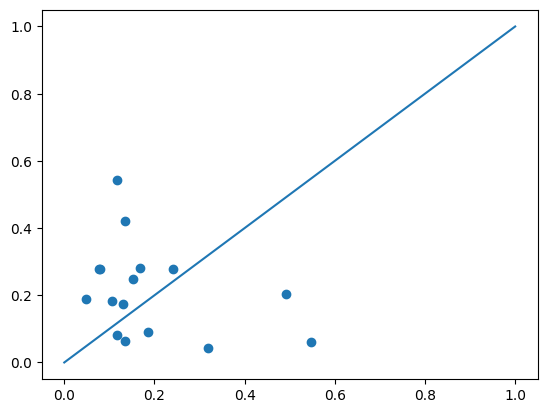

In [80]:
plt.scatter( outputs.detach().cpu().numpy(), targets.detach().cpu().numpy())
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))

0.0008544224099176446 0.052047446059683956


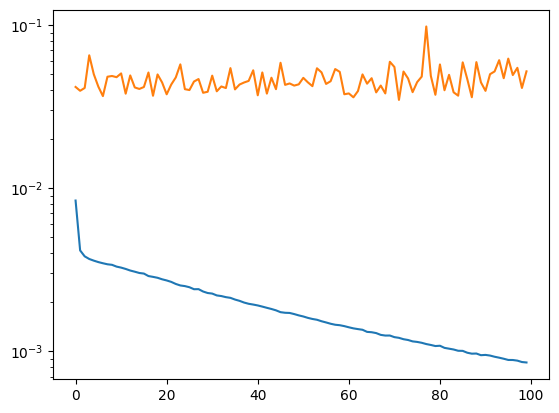

In [81]:
import matplotlib.pyplot as plt
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)
print(epoch_loss_train[-1],epoch_loss_val[-1])

In [82]:
# torch.save(model.state_dict(),"model_mlp")
# model.load_state_dict(torch.load("model_general"))
# model = model.to(device)

In [83]:
### Deploying trained model on test dataset ###
train_predictions = list()
for i in range(len(train_inputs)):
    temp_input = torch.tensor(train_inputs[i,:][None,:]).cuda().float()
    train_predictions.append(model(temp_input))

train_predictions = torch.stack(train_predictions).detach().cpu().numpy()
train_results = np.concatenate((train_inputs,train_predictions[:,0]),axis=1)
train_results = scaler.inverse_transform(train_results)
train_results_pd = pd.DataFrame(np.concatenate( (train_results[:,[-4,-3,-1]],train_data_pd["Drag_local"].values[:,None]),axis=1)
                                ,columns=["Re","Phi","Pred","GT"])

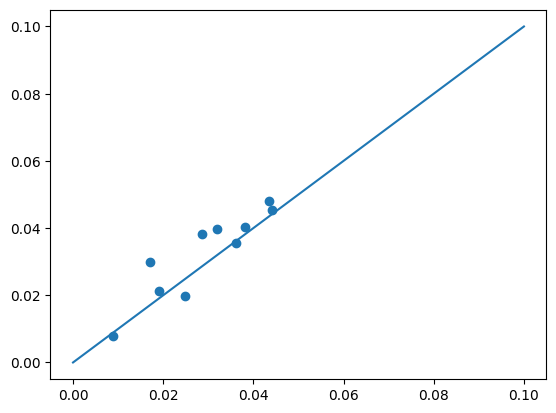

In [84]:
df_result = pd.DataFrame(np.concatenate((train_outputs,train_predictions[:,0]),axis=1),columns=["GT","Pred"])
plt.scatter(df_result["GT"].iloc[0:10],df_result["Pred"].iloc[0:10])
plt.plot(np.linspace(0,0.1,10),np.linspace(0,0.1,10))

In [85]:
### Deploying trained model on test dataset ###
test_predictions = list()
for i in range(len(test_inputs)):
    temp_input = torch.tensor(test_inputs[i,:][None,:]).cuda().float()
    test_predictions.append(model(temp_input))

test_predictions = torch.stack(test_predictions).detach().cpu().numpy()

In [86]:
test_results = np.concatenate((test_inputs,test_predictions[:,0]),axis=1)
test_results = scaler.inverse_transform(test_results)
test_results_pd = pd.DataFrame(np.concatenate( (test_results[:,[-4,-3,-1]],test_data_pd["Drag_local"].values[:,None]),axis=1)
                                ,columns=["Re","Phi","Pred","GT"])

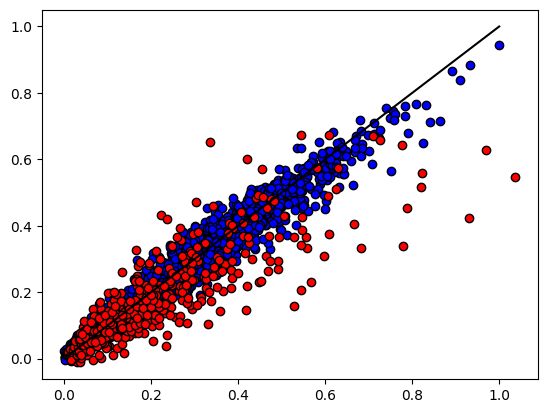

In [87]:
plt.scatter(train_outputs,train_predictions,c="blue",edgecolor='black')
plt.scatter(test_outputs,test_predictions,c="red",edgecolor='black')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),c='black')

In [ ]:
test_results_pd["Rel_err"] = np.abs(test_results_pd["GT"]-test_results_pd["Pred"])/(test_results_pd["GT"])
test_results_pd["Rel_err"]
plt.plot(test_results_pd["Rel_err"])
# count, bins_count = np.histogram(data, bins=10) 
  
# # finding the PDF of the histogram using count values 
# pdf = count / sum(count) 
  
# # using numpy np.cumsum to calculate the CDF 
# # We can also find using the PDF values by looping and adding 
# cdf = np.cumsum(pdf) 
  
# # plotting PDF and CDF 
# plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
# plt.plot(bins_count[1:], cdf, label="CDF") 
# plt.legend() 

In [ ]:
Re=10
Phi=30

test_subgroup = test_results_pd[(test_results_pd["Re"]==Re)&(test_results_pd["Phi"]==Phi)]
plt.scatter(test_subgroup["GT"],test_subgroup["Pred"],c="red",edgecolor='black')
plt.plot(np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),
         np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),c='black')
print(r2_score(test_subgroup["GT"].values,test_subgroup["Pred"].values))

In [ ]:
gt = test_subgroup["GT"].values
mean = np.ones(len(test_subgroup))*test_subgroup["GT"].values.mean()
pred = test_subgroup["Pred"].values

rel_err_mean = (np.abs(gt-mean)/(gt))*100
rel_err_pred = (np.abs(gt-pred)/(gt))*100
rel_err_mean.mean()

In [ ]:
rel_err_pred.mean()

Garbage

In [ ]:
# drags = np.concatenate( (all_data_pd["Drag_local"].values[0:207*4+402*4],
#                  all_data_pd[(all_data_pd["Re"]==10)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
#                  all_data_pd[(all_data_pd["Re"]==50)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
#                  all_data_pd[(all_data_pd["Re"]==100)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
#                  all_data_pd[(all_data_pd["Re"]==200)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values))
# drags

# np.save("ze_drags_2p5",all_data_pd["Drag_local"].values)